In [74]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
torch.backends.cudnn.deterministic = True

In [84]:
NUM_CLASSES = 9
ZDIM = 10
BATCH_SIZE = 128

In [85]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

def delete_class(dataset, to_delete):
    targets = np.array([np.where(np.array(dataset.targets) != to_delete)])[0][0]
    dataset.targets = np.array(dataset.targets)[targets]
    dataset.data = dataset.data[targets]
    
    return dataset

def mv_class(dataset, from_, to):
    targets = np.array([np.where(np.array(dataset.targets) == from_)])[0][0]
    dataset.targets = np.array(dataset.targets)
    dataset.targets[targets] = to
    
    return dataset

train_dataset = datasets.CIFAR10(root='data',
                                 train=True, 
                                 transform=transform_train,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data',
                                train=False, 
                                transform=transform_test)
test_dataset_show = datasets.CIFAR10(root='data', train=False)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=20,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=20,
                         shuffle=False)

Files already downloaded and verified


In [86]:
import pytorch_lightning as pl
from bottleneckresnet import resnet18


class ResNetFuzzy(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=NUM_CLASSES, z_dim=ZDIM, fuzzy=True)
        self.loss = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_no):
        x, y = batch
        logits, _ = self(x)
        Y = torch.zeros(logits.shape, dtype=torch.float32, device='cuda')
        for i in range(len(y)):
            ind = y[i]
            Y[i, ind] = 1
        y = Y

        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        return [optimizer], [scheduler]


class ResNetSimple(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=NUM_CLASSES, z_dim=ZDIM, fuzzy=False)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_no):
        x, y = batch
        logits, _ = self(x)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        return [optimizer], [scheduler]

In [87]:
fuzzy_model = ResNetFuzzy.load_from_checkpoint(f"resnet18-{ZDIM}-fuzzy_2.pt", map_location="cuda")
simple_model = ResNetSimple.load_from_checkpoint(f"resnet18-{ZDIM}-simple_2.pt", map_location="cuda")

In [88]:
from tqdm.autonotebook import tqdm

def get_prediction(x, model: pl.LightningModule):
    model.freeze()
    pred, z = model(x.to('cuda'))
    probabilities = torch.softmax(pred, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, pred, z

simple_true_y, simple_pred_y, simple_probs, simple_z = [], [], [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    simple_true_y.extend(y)
    preds, probs, z = get_prediction(x, simple_model)
    simple_z.extend(z.cpu())
    simple_pred_y.extend(preds.cpu())
    simple_probs.extend(probs.cpu())

fuzzy_true_y, fuzzy_pred_y, fuzzy_probs, fuzzy_z = [], [], [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    fuzzy_true_y.extend(y)
    preds, probs, z = get_prediction(x, fuzzy_model)
    fuzzy_z.extend(z.cpu())
    fuzzy_pred_y.extend(preds.cpu())
    fuzzy_probs.extend(probs.cpu())

simple_z = np.asarray([z.numpy() for z in simple_z])
fuzzy_z = np.asarray([z.numpy() for z in fuzzy_z])
simple_true_y = np.asarray([z.numpy() for z in simple_true_y])
simple_pred_y = np.asarray([z.numpy() for z in simple_pred_y])
fuzzy_true_y = np.asarray([z.numpy() for z in fuzzy_true_y])
fuzzy_pred_y = np.asarray([z.numpy() for z in fuzzy_pred_y])
simple_probs = np.asarray([z.numpy() for z in simple_probs])
fuzzy_probs = np.asarray([z.numpy() for z in fuzzy_probs])

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

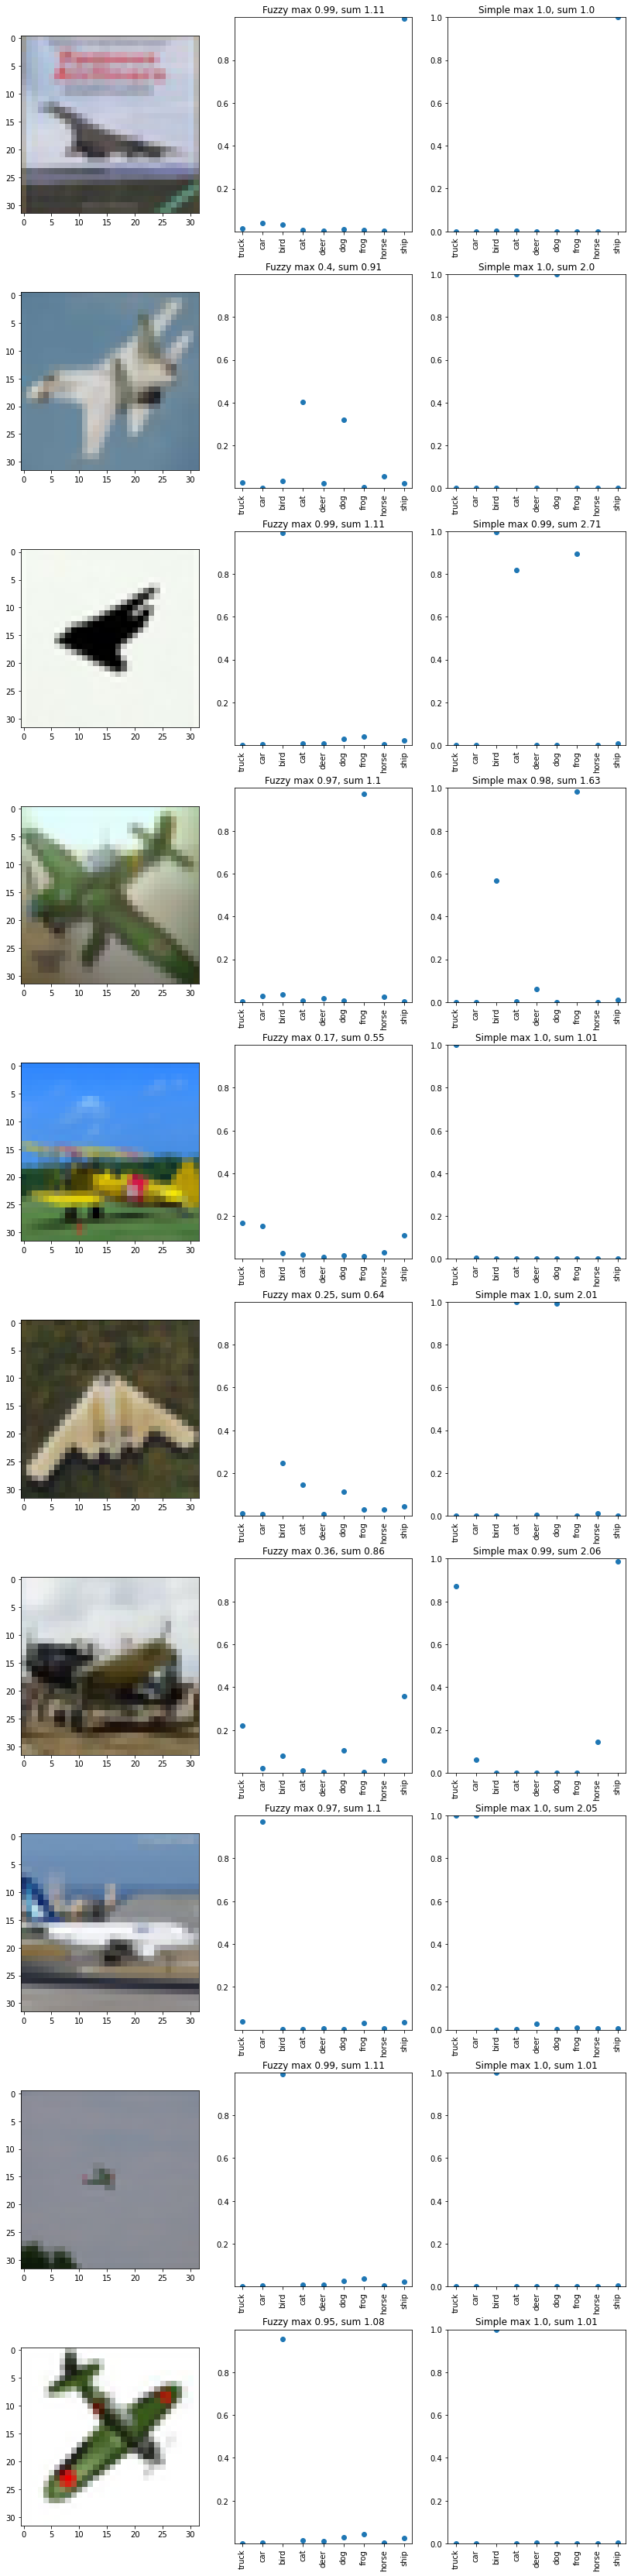

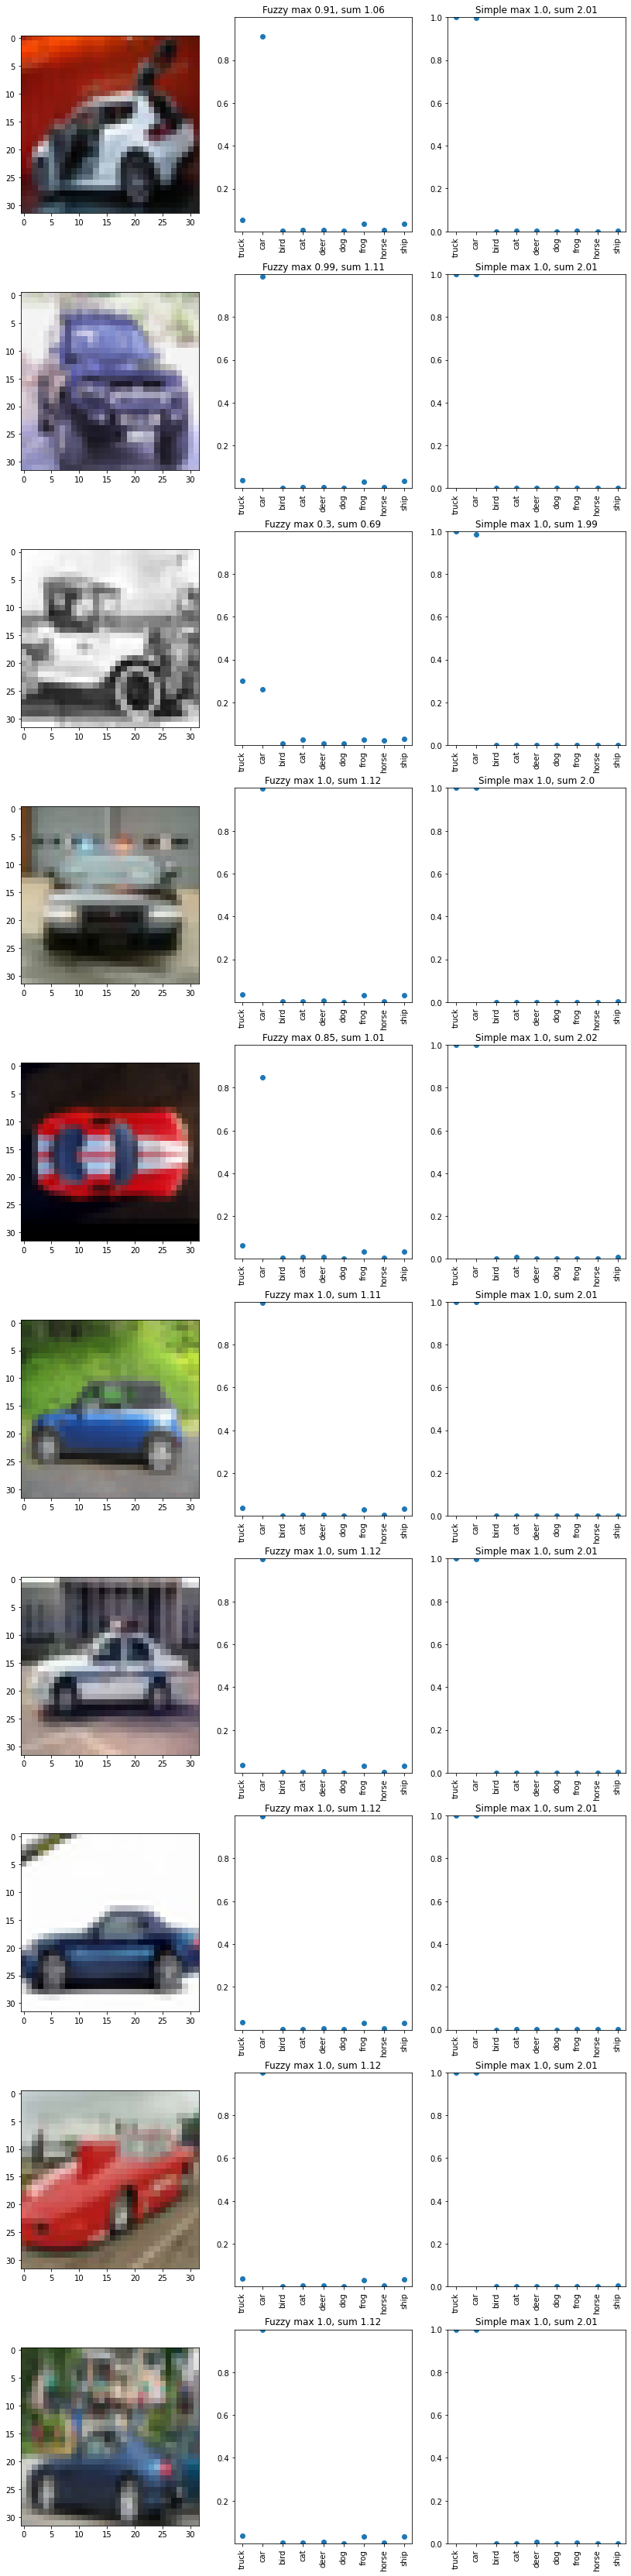

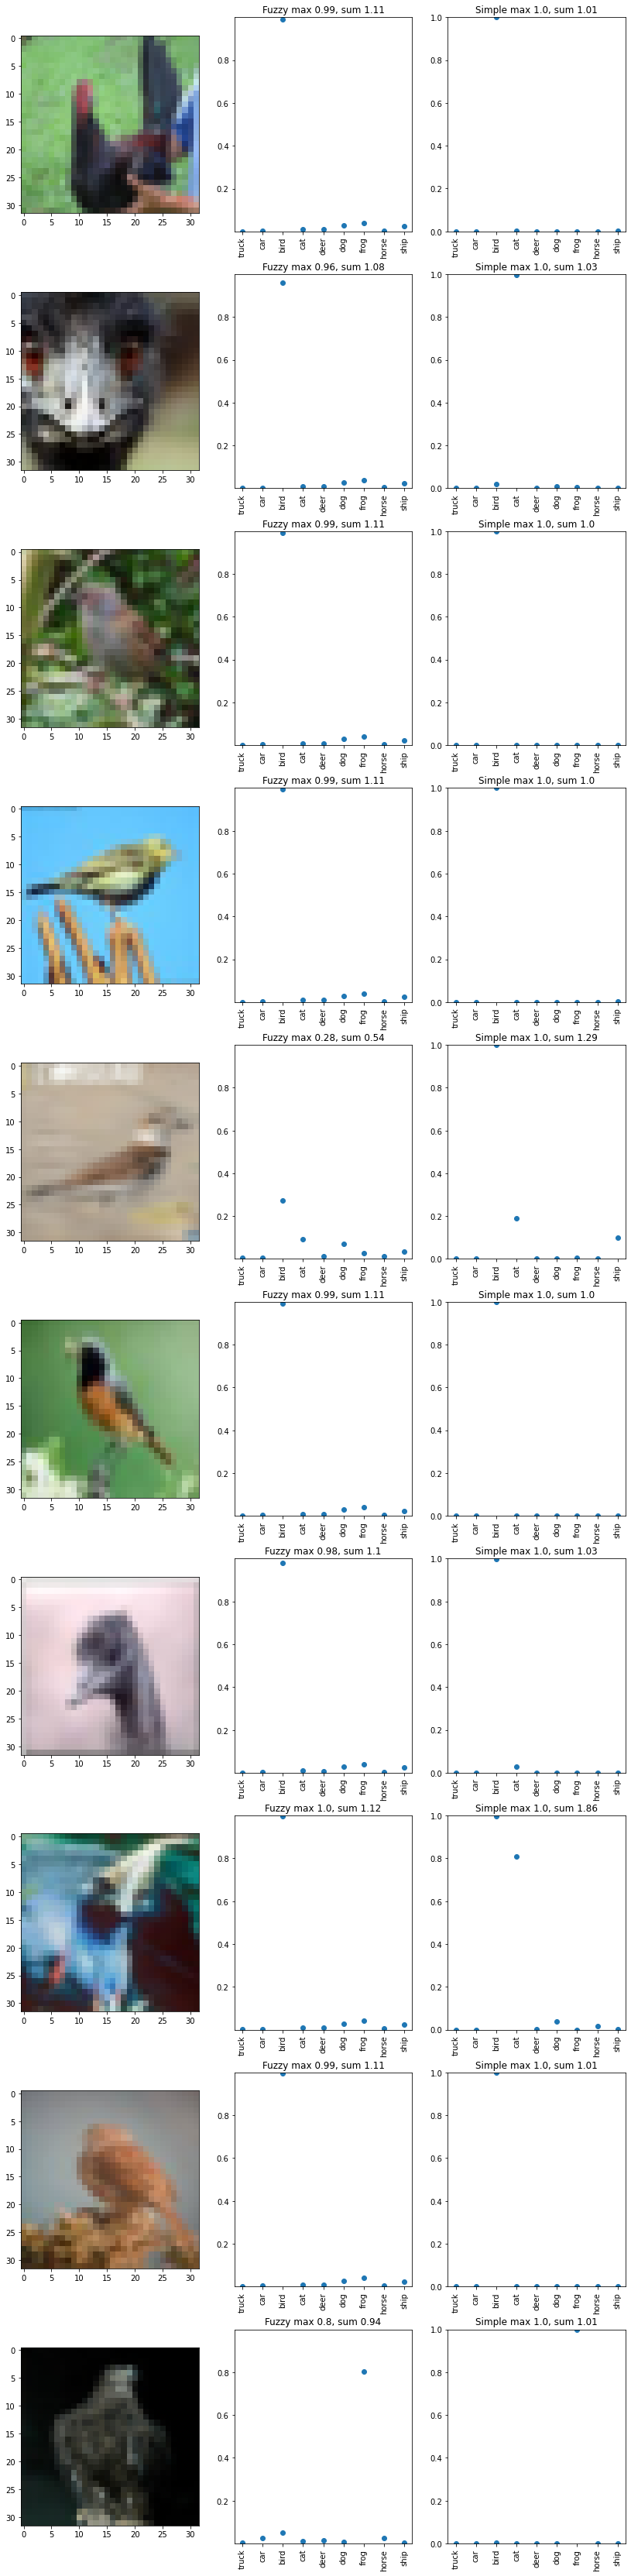

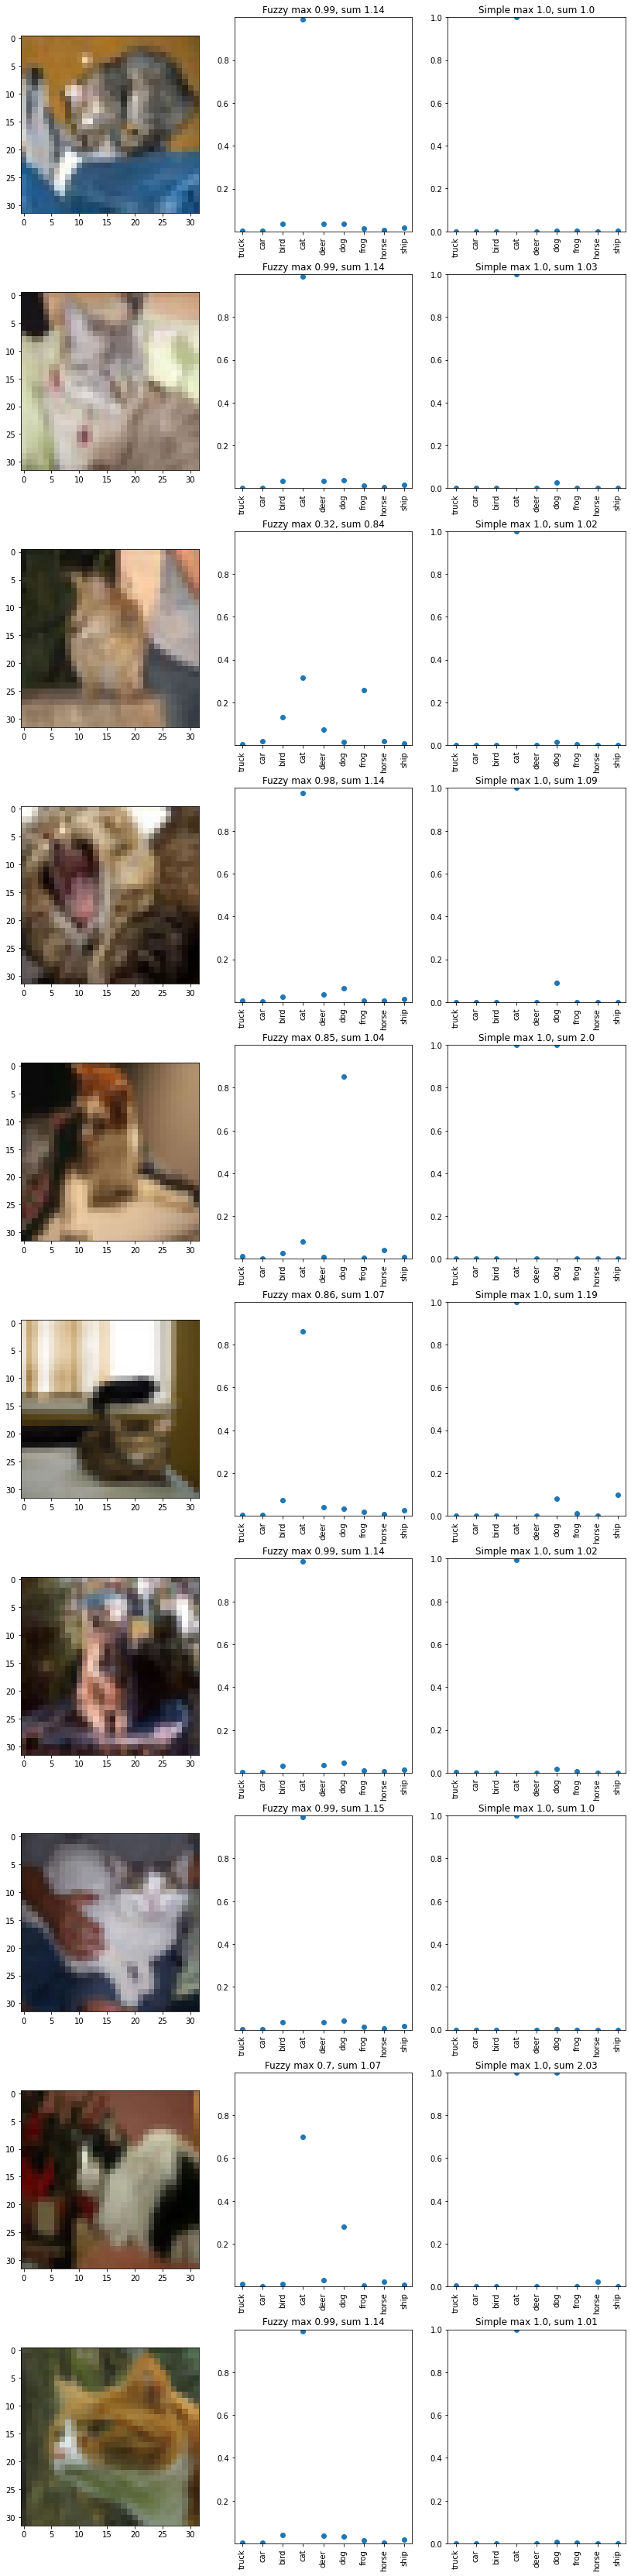

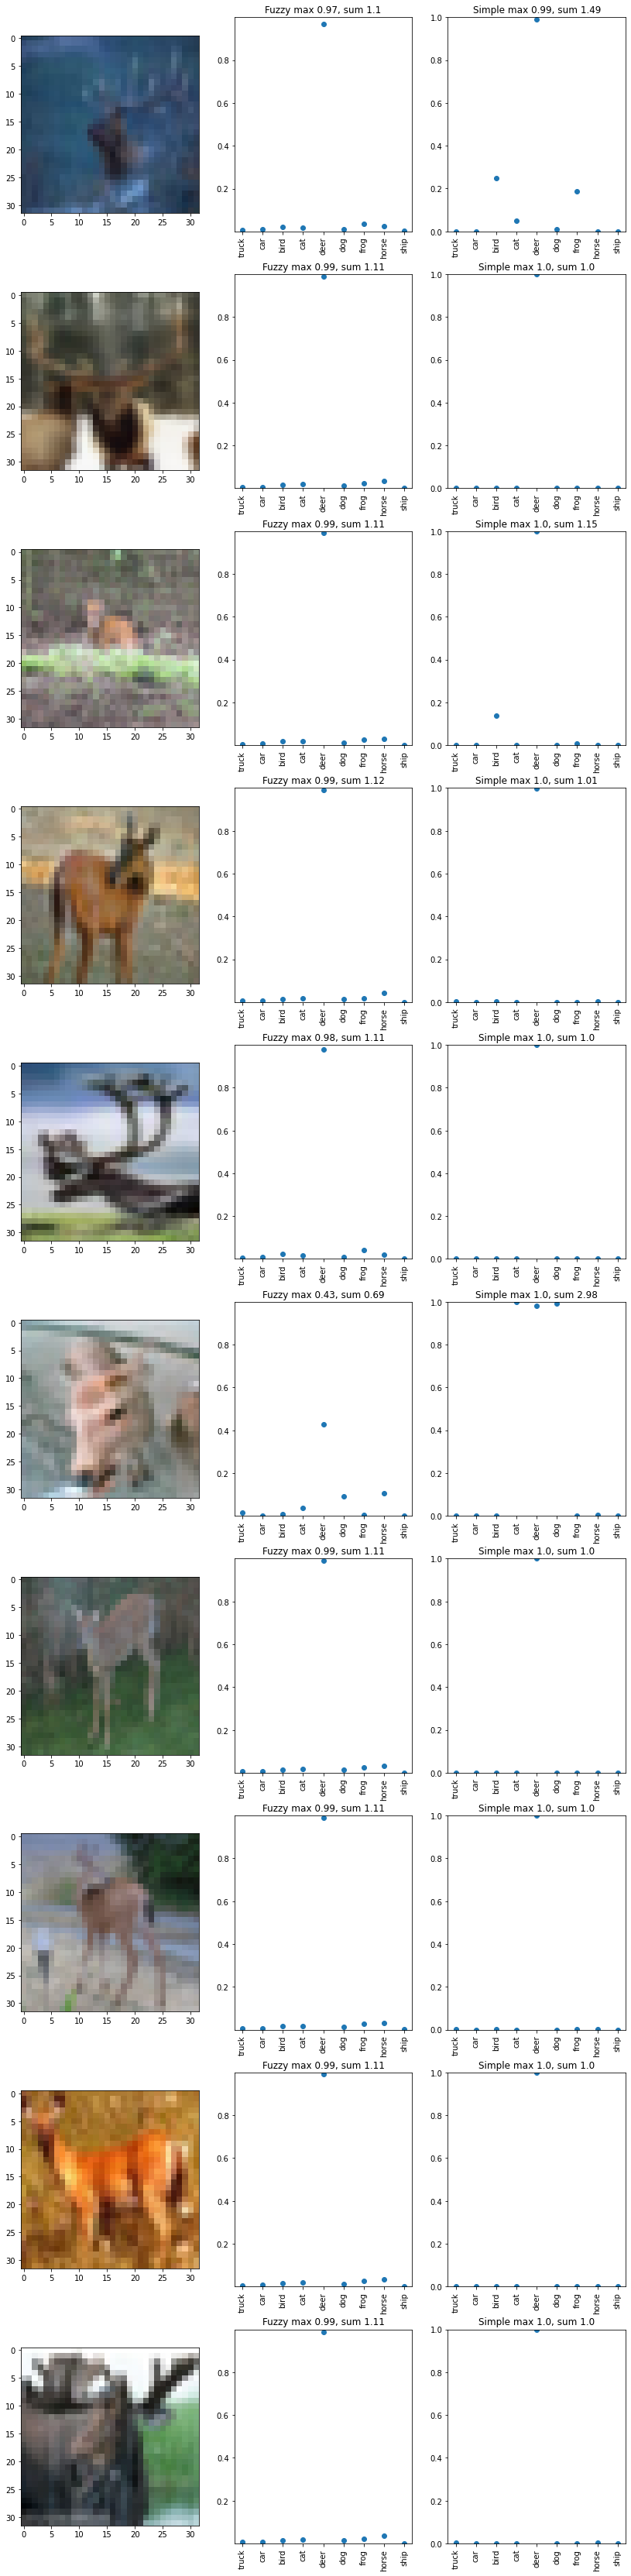

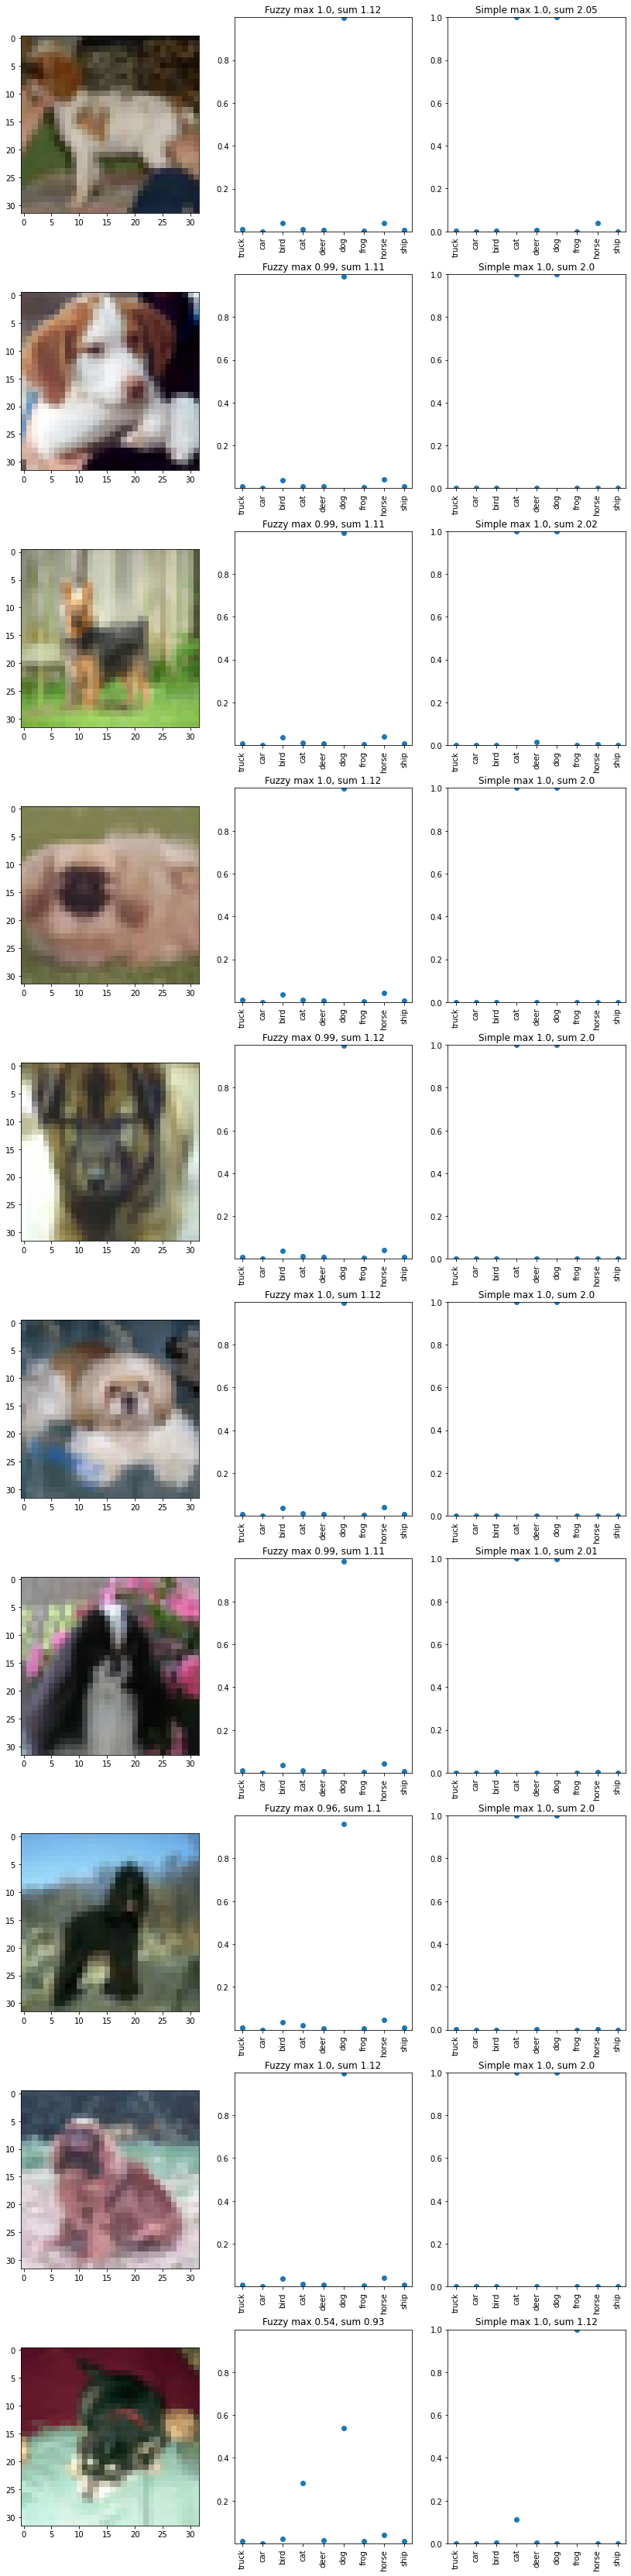

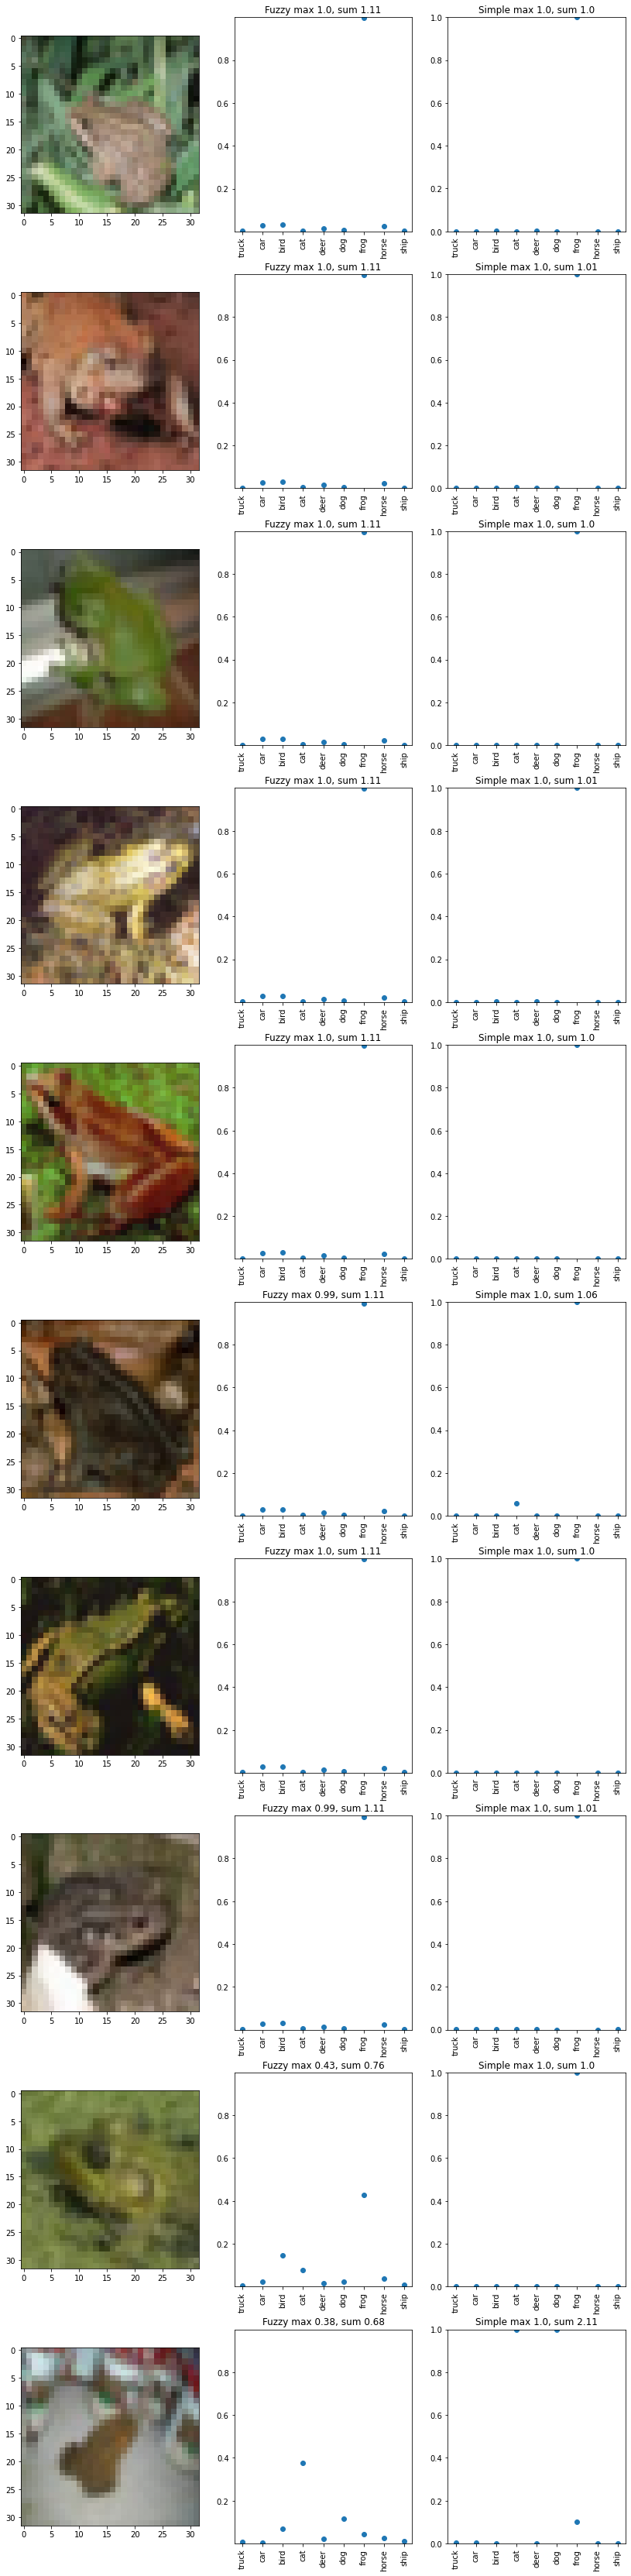

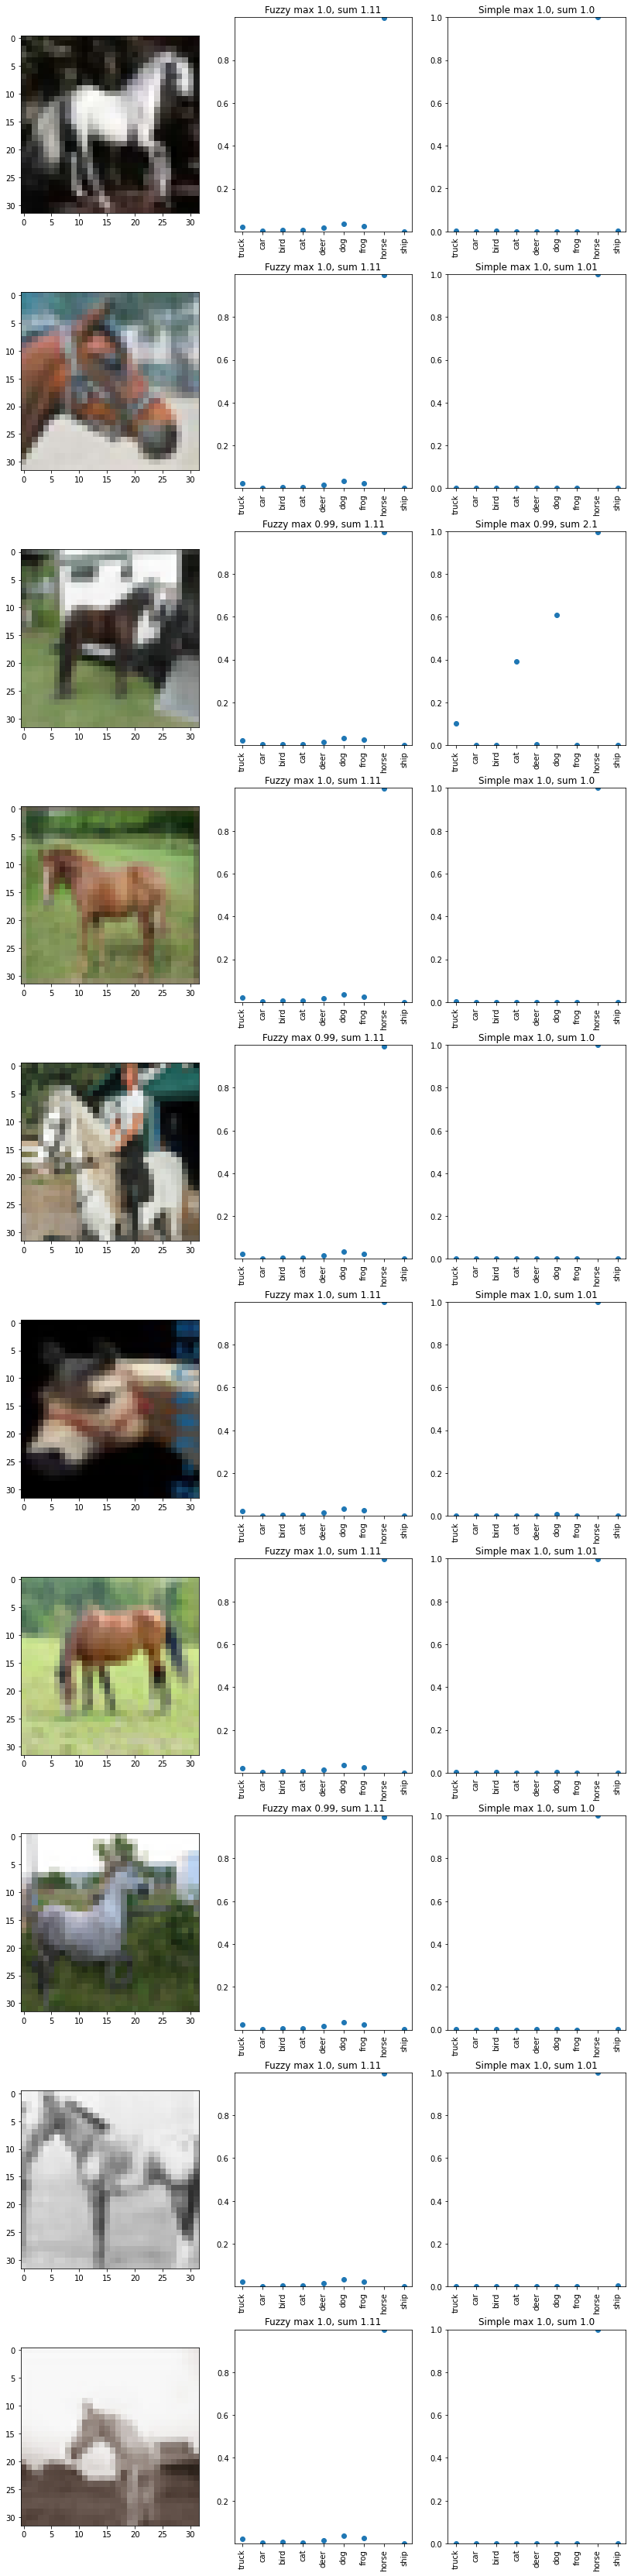

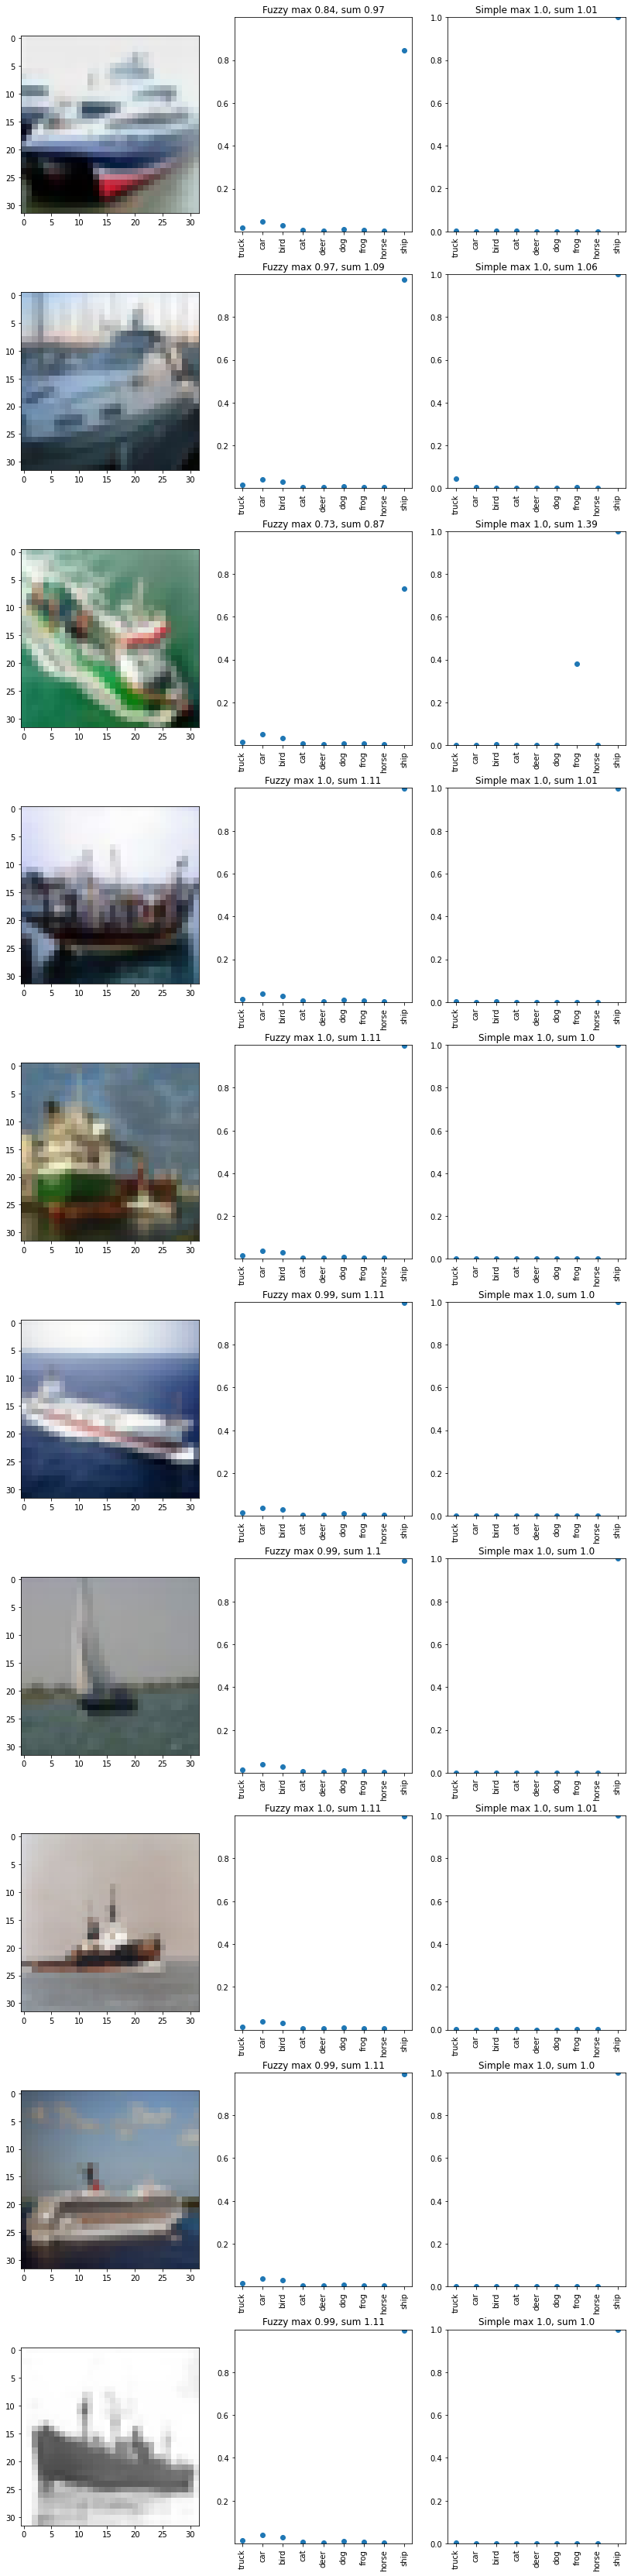

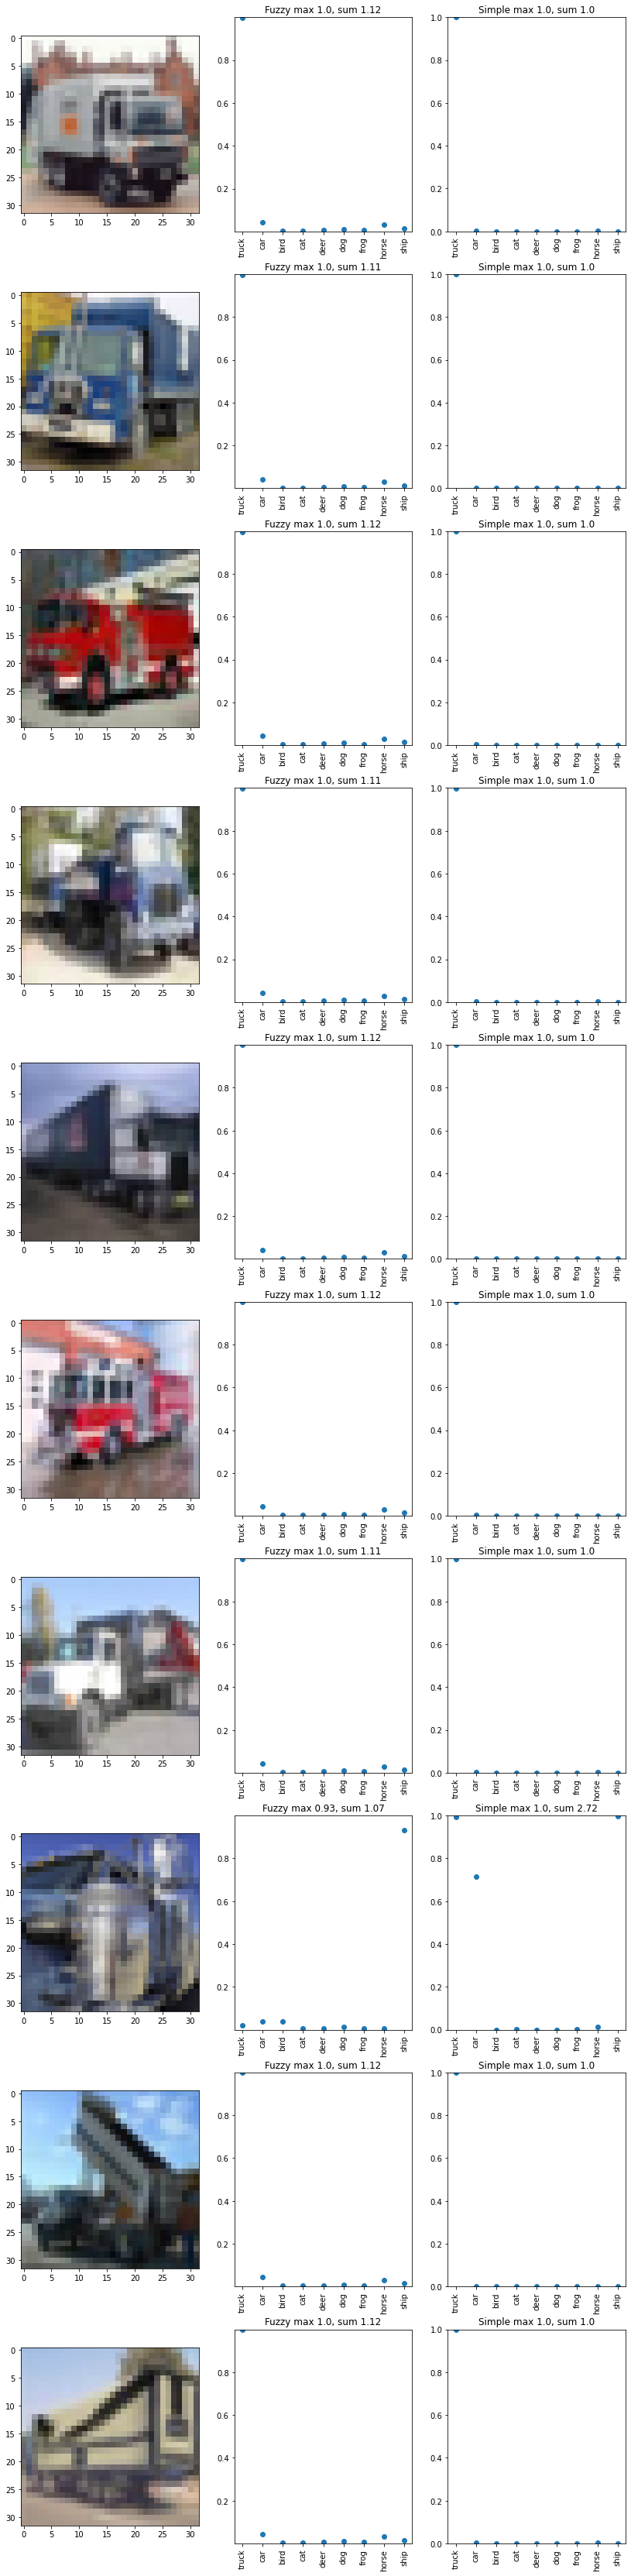

In [80]:
os.makedirs("data", exist_ok=True)

classes_train = ('truck', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship')
classes_real = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

images_to_show = 10

for classshow in classes_real:
#for classshow in ['plain']:
    targets = np.array([np.where(np.array(fuzzy_true_y) == classes_real.index(classshow))])[0][0]
    test_fuzzy_probs = fuzzy_probs[targets]
    test_simple_probs = simple_probs[targets]
    test_dataset_show_data = test_dataset_show.data[targets]

    fig, ax = plt.subplots(images_to_show, 3, figsize=(14, 6 * images_to_show))

    for i in range(0, images_to_show):
        ax[i, 0].imshow(test_dataset_show_data[i])
        
        ax[i, 1].set_ylim(np.min(fuzzy_probs), np.max(fuzzy_probs))
        ax[i, 1].scatter(range(len(test_fuzzy_probs[0])), test_fuzzy_probs[i])
        ax[i, 1].set_xticks(range(NUM_CLASSES), classes_train, rotation='vertical')
        smax = round(float(np.max(test_fuzzy_probs[i])), 2)
        ssum = round(float(np.sum(test_fuzzy_probs[i])), 2)
        ax[i, 1].set_title(f'Fuzzy max {round(smax, 2)}, sum {round(ssum, 2)}')

        ax[i, 2].set_ylim(np.min(simple_probs), np.max(simple_probs))
        ax[i, 2].scatter(range(len(test_simple_probs[0])), test_simple_probs[i])
        fmax = round(float(np.max(test_simple_probs[i])), 2)
        fsum = round(float(np.sum(test_simple_probs[i])), 2)
        ax[i, 2].set_title(f'Simple max {fmax}, sum {fsum}')
        ax[i, 2].set_xticks(range(NUM_CLASSES), classes_train, rotation='vertical')

    plt.savefig(f'data/{classshow}_ZDIM{ZDIM}.jpg')
    plt.show()

In [89]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2)
simple_tsne = tsne.fit_transform(simple_z)
df_simple = pd.DataFrame()
df_simple["y"] = simple_true_y
df_simple["comp-1"] = simple_tsne[:,0]
df_simple["comp-2"] = simple_tsne[:,1]

tsne = TSNE(n_components=2)
fuzzy_tsne = tsne.fit_transform(fuzzy_z)
df_fuzzy = pd.DataFrame()
df_fuzzy["y"] = fuzzy_true_y
df_fuzzy["comp-1"] = fuzzy_tsne[:,0]
df_fuzzy["comp-2"] = fuzzy_tsne[:,1]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'T-SNE Fuzzy | layer size 10')]

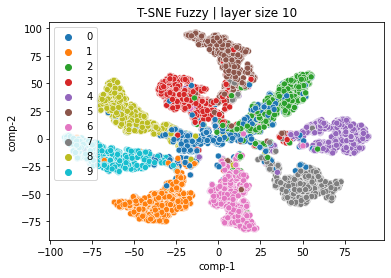

In [90]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df_fuzzy.y.tolist(),
                palette=sns.color_palette(n_colors=10),
                data=df_fuzzy).set(title=f"T-SNE Fuzzy | layer size {ZDIM}")

[Text(0.5, 1.0, 'T-SNE Simple | layer size 10')]

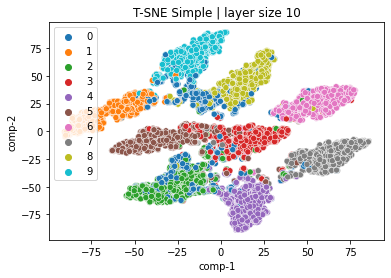

In [91]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df_simple.y.tolist(),
                palette=sns.color_palette(n_colors=10),
                data=df_simple).set(title=f"T-SNE Simple | layer size {ZDIM}")

Errors = 164 | 0.0164%


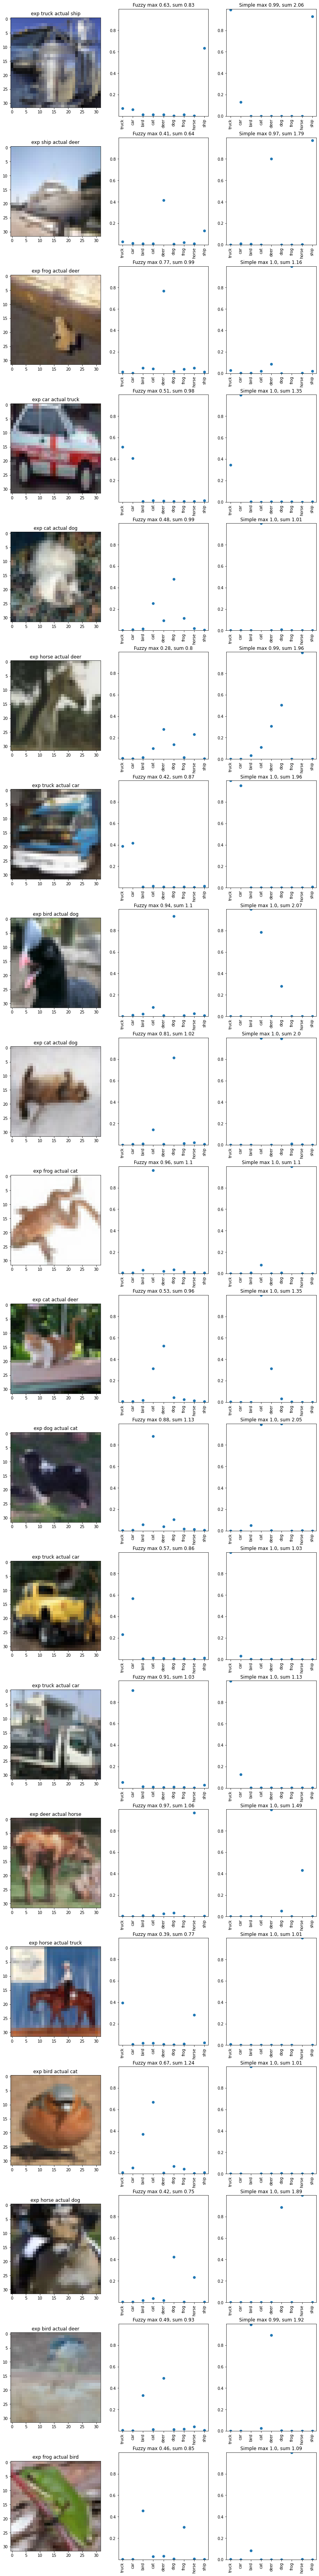

In [73]:
os.makedirs("data", exist_ok=True)

classes_train = np.array(['truck', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship'])
classes_real = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

images_to_show = 20

targets_desc = "Fuzzy_error_Simple_not_error"
targets = np.where(
    (classes_real[fuzzy_true_y] != classes_train[fuzzy_pred_y]) & 
    (classes_real[simple_true_y] == classes_train[simple_pred_y]) & 
    (fuzzy_true_y != np.where(classes_real == 'plane')[0][0])
)[0]

# targets_desc = "Fuzzy_error_Simple_error"
# targets = np.where(
#     (classes_real[fuzzy_true_y] != classes_train[fuzzy_pred_y]) & 
#     (classes_real[simple_true_y] != classes_train[simple_pred_y]) & 
#     (fuzzy_true_y != np.where(classes_real == 'plane')[0][0])
# )[0]

# targets_desc = "Fuzzy_not_error_Simple_error"
# targets = np.where(
#     (classes_real[fuzzy_true_y] == classes_train[fuzzy_pred_y]) & 
#     (classes_real[simple_true_y] != classes_train[simple_pred_y]) & 
#     (fuzzy_true_y != np.where(classes_real == 'plane')[0][0])
# )[0]

print(f"Errors = {len(targets)} | {len(targets)/len(fuzzy_pred_y)}%")

test_fuzzy_true_y = fuzzy_true_y[targets]
test_fuzzy_pred_y = fuzzy_pred_y[targets]
test_fuzzy_probs = fuzzy_probs[targets]
test_simple_probs = simple_probs[targets]
test_dataset_show_data = test_dataset_show.data[targets]

fig, ax = plt.subplots(images_to_show, 3, figsize=(14, 6 * images_to_show))

for i in range(0, images_to_show):
    ax[i, 0].imshow(test_dataset_show_data[i])
    exp = classes_real[test_fuzzy_true_y[i]]
    actual = classes_train[test_fuzzy_pred_y[i]]
    ax[i, 0].set_title(f'exp {exp} actual {actual}')

    ax[i, 1].set_ylim(np.min(fuzzy_probs), np.max(fuzzy_probs))
    ax[i, 1].scatter(range(len(test_fuzzy_probs[0])), test_fuzzy_probs[i])
    ax[i, 1].set_xticks(range(NUM_CLASSES), classes_train, rotation='vertical')
    smax = round(float(np.max(test_fuzzy_probs[i])), 2)
    ssum = round(float(np.sum(test_fuzzy_probs[i])), 2)
    ax[i, 1].set_title(f'Fuzzy max {round(smax, 2)}, sum {round(ssum, 2)}')

    ax[i, 2].set_ylim(np.min(simple_probs), np.max(simple_probs))
    ax[i, 2].scatter(range(len(test_simple_probs[0])), test_simple_probs[i])
    fmax = round(float(np.max(test_simple_probs[i])), 2)
    fsum = round(float(np.sum(test_simple_probs[i])), 2)
    ax[i, 2].set_title(f'Simple max {fmax}, sum {fsum}')
    ax[i, 2].set_xticks(range(NUM_CLASSES), classes_train, rotation='vertical')

plt.savefig(f'data/{targets_desc}_ZDIM{ZDIM}.jpg')
plt.show()

In [42]:
# %matplotlib inline


# fuzzy_acc = np.array([[0.928, 0.989, 0.988, 0.989, 0.986, 0.983, 0.989, 0.983, 0.985],
#              [0.955, 0.967, 0.99, 0.975, 0.982, 0.983, 0.986, 0.987, 0.986]])
# simple_acc = np.array([[0.978, 0.986, 0.983, 0.968, 0.986, 0.977, 0.988, 0.99, 0.986],
#               [0.982, 0.974, 0.98, 0.984, 0.986, 0.991, 0.986, 0.98, 0.988]])
# xs = list(range(2, 11))

# for i, fa in enumerate(fuzzy_acc):
#     if i == 0:
#         plt.semilogy(xs, fa, label='fuzzy', c='orange', alpha=0.3)
#     else:
#         plt.semilogy(xs, fa, c='orange', alpha=0.3)

# plt.semilogy(xs, np.mean(fuzzy_acc, axis=0), label='fuzzy-avg', c='red')

# for i, sa in enumerate(simple_acc):
#     if i == 0:
#         plt.semilogy(xs, sa, label='simple', c='green', alpha=0.2)
#     else:
#         plt.semilogy(xs, sa, c='green', alpha=0.2)

# plt.semilogy(xs, np.mean(simple_acc, axis=0), label='simple-avg', c='blue')

# plt.xlabel("Latent dims")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.savefig("acc_dims.jpg")
# plt.show()